In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
%matplotlib inline

In [2]:
cal_dir = './camera_cal/'
cal_files = os.listdir(cal_dir)

(720, 1280)


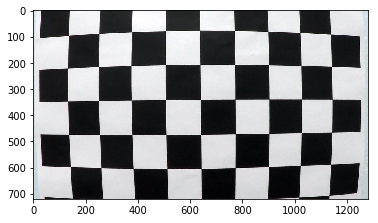

In [40]:
img = cv2.imread(cal_dir+cal_files[0])
img_shape = img.shape[:2]
plt.imshow(img)
plt.savefig('./output_images/chess_original.png')
print(img_shape)

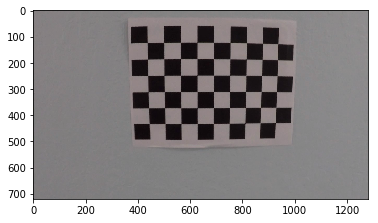

In [4]:
plt.imshow(img)

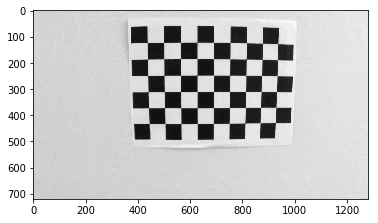

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [6]:
#camera calibration
nx = 9
ny = 6
objpoints = []
imgpoints = []

#undistorted chessboard coordinates
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

def findchess(image_file_list, nx=9, ny=6, image_dir=None):
    """
    get corners using calibration images
    fills the objpoints and imgpoints lists
    """
    global objpoints, imgpoints
    for image_file in image_file_list:
        image = cv2.imread(image_dir+image_file)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(image, (nx, ny), None)                               
    
        #if able to find corders, append to objpoints and imgpoints
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

#get chessboard coordinates
findchess(cal_files,image_dir=cal_dir)
#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

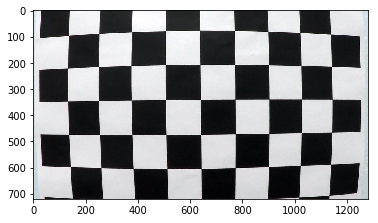

In [41]:
plt.imshow(img)


In [42]:
#undistort image using values from findchess()
dst = cv2.undistort(img, mtx, dist, None, mtx)

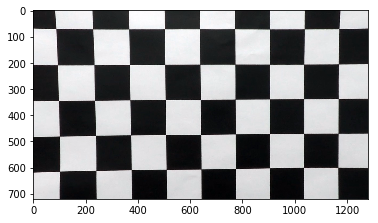

In [44]:
plt.imshow(dst)
plt.savefig('./output_images/chess-undistorted.png')

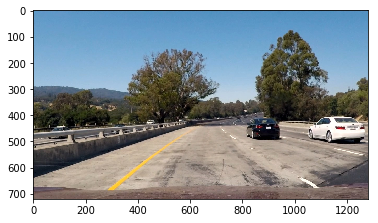

In [37]:
path = './test_images/test1.jpg'
img = cv2.imread(path)
#img = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.savefig('./output_images/original.png')

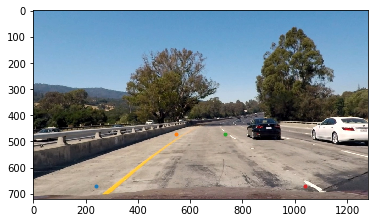

In [11]:
plt.imshow(img)
plt.plot(240,670,".")
plt.plot(545,470,".")
plt.plot(735,470,".")
plt.plot(1040,670,".")

In [12]:
################### Line Detection ###################
def abs_sobel_thresh(img, thresh=(0,255), orient='x', kernel_size=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = kernel_size))
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize = kernel_size))
    #convert to 8-bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    gradiant_binary = np.zeros_like(scaled_sobel)
    gradiant_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return gradiant_binary


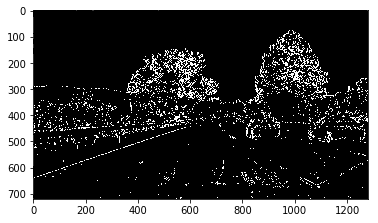

In [47]:
thresh_min = 20
thresh_max = 100
kernel_size = 3
path = './test_images/test1.jpg'
img = cv2.imread(path)
sobeled = abs_sobel_thresh(img, thresh=(thresh_min,thresh_max), orient='x', kernel_size=kernel_size)
plt.imshow(sobeled, cmap='gray')

In [14]:

def mag_thresh(img, thresh=(0,255), kernel_size=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = kernel_size))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize = kernel_size))

    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    grandmag = (gradmag/scale_factor).astype(np.uint8)

    binary_output = np.zeros_like(grandmag)
    binary_output[(grandmag >= thresh[0]) & (grandmag <= thresh[1])] = 1
    
    return binary_output


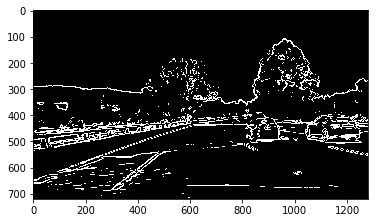

In [15]:
thresh_min = 50
thresh_max = 150
kernel_size = 15
path = './test_images/test4.jpg'
img = cv2.imread(path)
sobeled = mag_thresh(img, thresh=(thresh_min,thresh_max), kernel_size=kernel_size)
plt.imshow(sobeled, cmap='gray')

In [16]:

def dir_threshold(img, thresh=(0,np.pi/2), kernel_size=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = kernel_size))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize = kernel_size))
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output


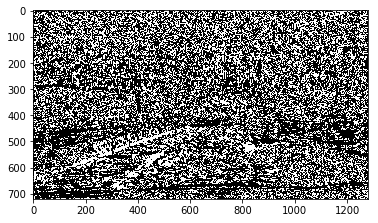

In [17]:
kernel_size = 23
thresh = (0.7, 1.3)
path = './test_images/test4.jpg'
img = cv2.imread(path)
sobeled = dir_threshold(img, thresh, kernel_size=kernel_size)
plt.imshow(sobeled, cmap='gray')

In [74]:
path = './test_images/test1.jpg'
img = cv2.imread(path)
gradx = abs_sobel_thresh(img, orient='x', kernel_size=kernel_size, thresh=(30, 100))
grady = abs_sobel_thresh(img, orient='y', kernel_size=kernel_size, thresh=(30, 100))
mag_binary = mag_thresh(img, kernel_size=kernel_size, thresh=(30, 100))
dir_binary = dir_threshold(img, kernel_size=kernel_size, thresh=(0, np.pi/2))

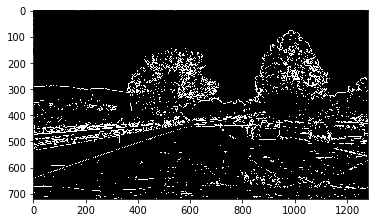

In [76]:
combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

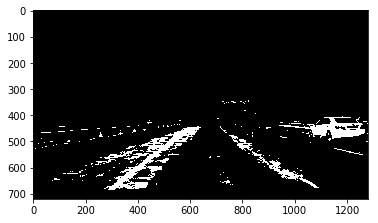

In [94]:
#HLS Color Threshold

def hls_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    #H = img[:,:,0]
    #L = img[:,:,1]
    S = img[:,:,2]
    
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output


path = './test_images/test1.jpg'
img = cv2.imread(path)
image = hls_threshold(img, thresh=(200,255))
plt.imshow(image, cmap="gray")


(720, 1280, 3)


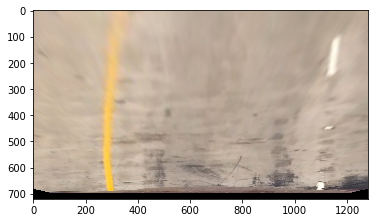

In [101]:
##undistort and transform
img = cv2.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

src = np.float32([
                  [240,670],
                  [560,470],
                  [720,470],
                  [1040,670],
                 ])

dst = np.float32([
                  [215,670],
                  [215,0],
                  [1065,0],
                  [1065,670],
])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def warp(img, src=src, dst=dst):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

#plt.imshow(img)
warped = warp(img)
plt.imshow(warped)
plt.savefig('./output_images/transform.png')

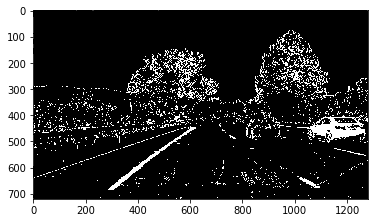

In [97]:
img = cv2.imread('./test_images/test1.jpg')
s_thresh=(215,255)
sx_thresh=(20,100)
s_binary = hls_threshold(img, thresh=s_thresh)
sxbinary = abs_sobel_thresh(img, thresh=sx_thresh, orient='x')
combined = np.zeros_like(sxbinary)
combined[(s_binary == 1) | (sxbinary == 1)] = 1
plt.imshow(combined, cmap="gray")
#plt.savefig('./output_images/threshdolded-s-xsobel.png')

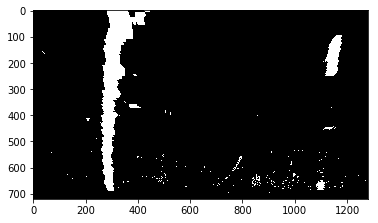

In [99]:

# Pipeline to process image (undistort, transform, binary)
img = cv2.imread('./test_images/test1.jpg')
s_thresh=(215,255)
sx_thresh=(20,100)
def process_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    input is an img and the threshold
    returns a transformed undistorted binary image
    and an undistorted image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #HLS threshold
    s_binary = hls_threshold(undist, thresh=s_thresh)
    
    #sobel threshold
    sxbinary = abs_sobel_thresh(undist, thresh=sx_thresh, orient='x')
    
    #combine
    combined = np.zeros_like(sxbinary)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    combined = warp(combined)
    return combined, undist

binary_warped, undist = process_image(img, s_thresh=s_thresh, sx_thresh=sx_thresh)
plt.imshow(binary_warped, cmap='gray')
plt.savefig('./output_images/threshold-transform.png')

In [23]:
print(binary_warped.shape)

(720, 1280)


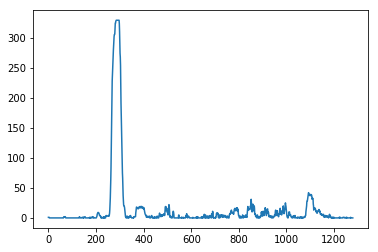

In [24]:

#detecting lane lines
#histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
#plt.plot(histogram)

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [25]:

#identify lane lines

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)




In [26]:

#identify lane lines as function

def lane_lines(binary_warped):
    """
    takes a binary_warped image
    
    return out_img, left_fitx, right_fitx
    
    returns an output_image that identifies left and right lane lines,
    returns the plot values of left left lane line,
    returns the plot values of right lane line
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, ploty, left_fitx, right_fitx


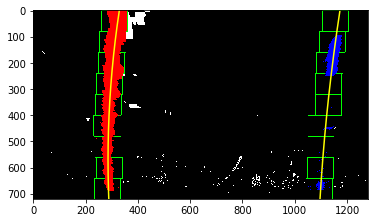

In [29]:
out_img, ploty, left_fitx, right_fitx = lane_lines(binary_warped)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

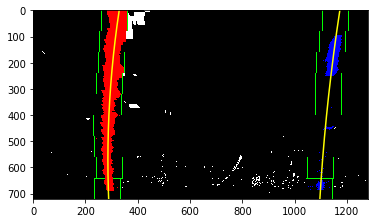

In [102]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./output_images/lane_line.png')

In [31]:
# get curvature
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1243.05133585 m 2536.43570022 m


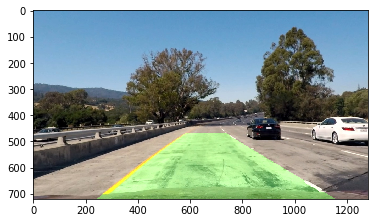

In [104]:
# Create an image to draw the lines on
##warp_zero = np.zeros_like(warped).astype(np.uint8)
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
undist_rgb = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
result = cv2.addWeighted(undist_rgb, 1, newwarp, 0.3, 0)
plt.imshow(result)


In [33]:

def draw(binary_warped, ploty, left_fitx, right_fitx, undist):
    # Create an image to draw the lines on
    ##warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist_rgb = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(undist_rgb, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

In [34]:
def pipeline(img):
    s_thresh=(215,255)
    sx_thresh=(20,100)
    binary_warped, undist = process_image(img, s_thresh=s_thresh, sx_thresh=sx_thresh)
    out_img, ploty, left_fitx, right_fitx = lane_lines(binary_warped)
    result = draw(binary_warped, ploty, left_fitx, right_fitx, undist)
    return result

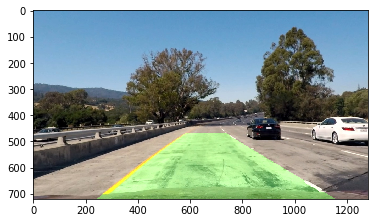

In [107]:
path = './test_images/test1.jpg'
img = cv2.imread(path)
result = pipeline(img)
plt.imshow(result)
plt.savefig('./output_images/final.png')

In [31]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'p4.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video p4.mp4
[MoviePy] Writing video p4.mp4


100%|█████████▉| 1260/1261 [03:16<00:00,  6.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4.mp4 

CPU times: user 3min 39s, sys: 42.7 s, total: 4min 22s
Wall time: 3min 18s
